In [1]:
import torch
import torch.nn as nn
import numpy as np
import numpy.random as npr
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.modules.utils import _pair
import math
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Code for ConvLSTM cell

In [2]:
class ConvRNNCellBase(nn.Module):

    def __repr__(self):
        s = '{name}({input_size}, {hidden_size}'
        if 'bias' in self.__dict__ and self.bias is not True:
            s += ', bias={bias}'
        if 'nonlinearity' in self.__dict__ and self.nonlinearity != "tanh":
            s += ', nonlinearity={nonlinearity}'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)
    
def ConvLSTM2dCellFn(input, hidden, w_ih, w_hh, b_ih=None, b_hh=None, in_stride=(1,1), hid_stride=(1,1), in_padding=0, hid_padding=0, in_dilation=(1,1), hid_dilation=(1,1)):

    hx, cx = hidden
    #print(F.conv2d(input, w_ih, b_ih, in_stride, in_padding, in_dilation).size(), F.conv2d(hx, w_hh, b_hh, hid_stride, hid_padding, hid_dilation).size() )
    gates = F.conv2d(input, w_ih, b_ih, in_stride, in_padding, in_dilation) + F.conv2d(hx, w_hh, b_hh, hid_stride, hid_padding, hid_dilation)
    
    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
    
    ingate = F.sigmoid(ingate)
    forgetgate = F.sigmoid(forgetgate)
    cellgate = F.tanh(cellgate)
    outgate = F.sigmoid(outgate)
    
    #print(ingate.size(), forgetgate.size(), cellgate.size(), outgate.size(), cx.size())
    
    cy = (forgetgate * cx) + (ingate * cellgate)
    hy = outgate * F.tanh(cy)

    return hy, cy

class ConvLSTM2dCell(ConvRNNCellBase):
    """A long short-term memory (LSTM) cell.

    .. math::

        \begin{array}{ll}
        i = \mathrm{sigmoid}(W_{ii} \star x + b_{ii} + W_{hi} \star h + b_{hi}) \\
        f = \mathrm{sigmoid}(W_{if} \star x + b_{if} + W_{hf} \star h + b_{hf}) \\
        g = \tanh(W_{ig} \star x + b_{ig} + W_{hc} h + b_{hg}) \\
        o = \mathrm{sigmoid}(W_{io} \star x + b_{io} + W_{ho} \star h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o * \tanh(c_t) \\
        \end{array}

        where \star denotes the convolution operator

        Args:
        input_channels (int): Number of channels in the input  
        hidden_channels (int): Number of channels in the hidden state
        in_kernel_size (int or tuple): Size of the convolving kernel for the input, must be odd
        hid_kernel_size (int or tuple): Size of the convolving kernel for the hidden state, must be odd
        in_stride (int or tuple, optional): Stride of the input convolution, Default: 1
        hid_stride (int or tuple, optional): Stride of the hidden convolution, Default: 1
        in_dilation (int or tuple, optional): Spacing between input convolving kernel elements, Default: 1
        hid_dilation (int or tuple, optional): Spacing between hidden convolving kernal elements, Default: 1
        bias (bool, optional): If `False`, then the layer does not use bias weights `b_ih` and `b_hh`. Default: True

    Inputs: input, (h_0, c_0)
        - **input** (batch, in_channels, C_in, H_in): tensor containing input features
        - **h_0** (batch, hidden_channels, C_in, H_in): tensor containing the initial hidden state for each element in the batch.
        - **c_0** (batch, hidden_channels, C_in, H_in): tensor containing the initial cell state for each element in the batch.

    Outputs: h_1, c_1
        - **h_1** (batch, hidden_channels, C_in, H_in): tensor containing the next hidden state for each element in the batch
        - **c_1** (batch, hidden_channels, C_in, H_in): tensor containing the next cell state for each element in the batch

    Attributes:
        weight_ih (Tensor): the learnable input-hidden weights, of shape (hidden_channels, in_channels, kernel_size[0], kernel_size[1])
        weight_hh: the learnable hidden-hidden weights, of shape  (hidden_channels, in_channels, kernel_size[0], kernel_size[1])
        bias_ih: the learnable input-hidden bias, of shape `(hidden_channels)`
        bias_hh: the learnable hidden-hidden bias, of shape `(hidden_channels)`

    Examples::

        >>> rnn = nn.ConvLSTM2dCell(10, 20, 3)
        >>> input = Variable(torch.randn(6, 3, 10, 12, 12))
        >>> hx = Variable(torch.randn(3, 20, 12, 12))
        >>> cx = Variable(torch.randn(3, 20, 12, 12))
        >>> output = []
        >>> for i in range(6):
        ...     hx, cx = rnn(input[i], (hx, cx))
        ...     output.append(hx)
    """
    def __init__(self, in_channels, hidden_channels, in_kernel_size, hid_kernel_size, in_stride=1, hid_stride=1, in_dilation=1, hid_dilation=1, bias=True):
        super(ConvLSTM2dCell, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
#         self.im_rows, self.im_cols = im_size
#         self.batch_size = batch_size
        self.in_kernel_size = _pair(in_kernel_size)
        
        if isinstance(in_kernel_size, int):
            self.in_padding = ((in_kernel_size-1)/2, (in_kernel_size-1)/2)
        else:
            self.in_padding = ((in_kernel_size[0]-1)/2, (in_kernel_size[1]-1)/2)
            
        if isinstance(hid_kernel_size, int):
            self.hid_padding = ((hid_kernel_size-1)/2, (hid_kernel_size-1)/2)
        else:
            self.hid_padding = ((hid_kernel_size[0]-1)/2, (hid_kernel_size[1]-1)/2)
            
        self.hid_kernel_size = _pair(hid_kernel_size)
        self.in_stride = _pair(in_stride)
        self.hid_stride = _pair(hid_stride)
        self.in_dilation = _pair(in_dilation)
        self.hid_dilation = _pair(hid_dilation)
        self.bias = bias

        self.weight_ih = Parameter(torch.Tensor(4 * self.hidden_channels, self.in_channels, *self.in_kernel_size))
        self.weight_hh = Parameter(torch.Tensor(4 * self.hidden_channels, self.hidden_channels, *self.hid_kernel_size))

        if bias:
            self.bias_ih = Parameter(torch.Tensor(4 * self.hidden_channels))
            self.bias_hh = Parameter(torch.Tensor(4 * self.hidden_channels))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.hid_kernel_size:
            n *= k
        stdv = 1. /math.sqrt(n)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def init_hidden(self, batch_size, im_size):
        im_rows, im_cols = im_size
        return Variable(torch.zeros(batch_size, self.hidden_channels, im_rows, im_cols)), Variable(torch.zeros(batch_size, self.hidden_channels, im_rows, im_cols))
        

    def forward(self, input, hx):
        return ConvLSTM2dCellFn(
            input, hx,
            self.weight_ih, self.weight_hh,
            self.bias_ih, self.bias_hh,
            self.in_stride, self.hid_stride,
            self.in_padding, self.hid_padding,
            self.in_dilation, self.hid_dilation
        )

### Notes for building convLSTM
For input args, we should give number of input and hidden layer channels. It will infer the number of rows and columns from the input that is given. We also need to give number of strides etc just like the conv2d layer. 

### Doesn't allow:
1. Groups
2. Multiple layers 
3. Conv transpose (hence, no output_padding)
4. bidirectional
5. Custom activation functions

### Other specifications:
1. Kernel size for the input and the recurrent convolutions are the same

### Remember to:
1. Make the kernel size a tuple
2. Remove the redundant _all_weights thing because there is only one layer
3. Change the reset_parameters. Not sure what the right init should be when we have conv filter like this

## Testing ConvLSTM2dCell 

Testing the ConvLSTM Cell for known weights

In [3]:
input = torch.Tensor([3, 4, 4])
input = input.cuda()

convlstm = ConvLSTM2dCell(3, 5, 3, 3, in_stride=1, hid_stride=1, in_dilation=1, hid_dilation=1, bias=False)

convlstm.cuda()

hidden = convlstm.init_hidden(1, (4, 4))
hidden = (hidden[0].cuda(), hidden[1].cuda())

list(convlstm.parameters())[0].data[:5] = torch.zeros(5, 3, 3, 3)
list(convlstm.parameters())[0].data[5:10] = torch.ones(5, 3, 3, 3)
list(convlstm.parameters())[0].data[10:15] = 2*torch.ones(5, 3, 3, 3)
list(convlstm.parameters())[0].data[15:] = 3*torch.ones(5, 3, 3, 3)
list(convlstm.parameters())[1].data[:5] = torch.zeros(5, 5, 3, 3)
list(convlstm.parameters())[1].data[5:10] = torch.ones(5, 5, 3, 3)
list(convlstm.parameters())[1].data[10:15] = 2*torch.ones(5, 5, 3, 3)
list(convlstm.parameters())[1].data[15:] = 3*torch.ones(5, 5, 3, 3)
list(convlstm.parameters())

input = Variable(torch.ones(1, 3, 4, 4), requires_grad=False)
input = input.cuda()
hidden = convlstm.forward(input, hidden)
convlstm.forward(input, hidden)

(Variable containing:
 (0 ,0 ,.,.) = 
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
 
 (0 ,1 ,.,.) = 
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
 
 (0 ,2 ,.,.) = 
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
 
 (0 ,3 ,.,.) = 
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
 
 (0 ,4 ,.,.) = 
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
   0.7616  0.7616  0.7616  0.7616
 [torch.cuda.FloatTensor of size 1x5x4x4 (GPU 0)], Variable containing:
 (0 ,0 ,.,.) = 
   1  1  1  1
   1  1  1  1
   1  1  1  1
   1  1  1  1
 
 (0 ,1 ,.,.) = 
   1  1  1  1
   1  1  1  1
   1  1  1  1
   1  

In [4]:
hidden[0]

Variable containing:
(0 ,0 ,.,.) = 
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621

(0 ,1 ,.,.) = 
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621

(0 ,2 ,.,.) = 
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621

(0 ,3 ,.,.) = 
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621

(0 ,4 ,.,.) = 
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
  0.4621  0.4621  0.4621  0.4621
[torch.cuda.FloatTensor of size 1x5x4x4 (GPU 0)]

## Building ConvLSTMEnc-Dec
Replicate the network built in Keras and train on confused ball dataset

### TODO:
1. Re-write code so hidden states for each layer don't have to be initialized separately
2. Change the optimizer
3. Plot the loss (check what to see with every epoch) and check loss magnitude between keras and this one
4. Weight init must be same as keras
5. Optimizer params must be same as keras

In [27]:
class ConvLSTMEncDec(nn.Module):
    def __init__(self):
        super(ConvLSTMEncDec, self).__init__()
        self.convEnc1 = nn.Conv2d(1, 50, 3, padding=1)
        self.ReLUEnc1 = nn.Threshold(0.0, 0.0)
        self.poolEnc1 = nn.MaxPool2d(2)
        self.convLSTM1 = ConvLSTM2dCell(50, 100, 3, 3)
        self.convLSTM0 = ConvLSTM2dCell(101, 100, 3, 3)
        self.deconvDec1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.convDec = nn.Conv2d(100, 1, 3, padding=1)
        
    def forward(self, input, R1_hidden, R0_hidden):
        A1_conv = self.convEnc1(input)
        A1_relu = self.ReLUEnc1(A1_conv)
        A1 = self.poolEnc1(A1_relu)
        R1_hidden = self.convLSTM1(A1, R1_hidden) 
        R0_input_topdown = self.deconvDec1(R1_hidden[0])
        R0_input = torch.cat((R0_input_topdown, input), dim=1)
        R0_hidden = self.convLSTM0(R0_input, R0_hidden)
        output = self.convDec(R0_hidden[0])
        return R1_hidden, R0_hidden, output

## Import data

In [6]:
import hickle as hkl
datapath = '/home/ybansal/Documents/Research/stochastic-prednet/Data/confused_ball/train.hkl'
f = open(datapath, 'r')
data_container = hkl.load(f)
f.close()
X_train = np.swapaxes(np.swapaxes(data_container['videos'][:,0:9], 3, 4), 2, 3)
Y_train = np.swapaxes(np.swapaxes(data_container['videos'][:,1:10], 3, 4), 2, 3)

In [7]:
X_train = Variable(torch.from_numpy(X_train.astype(np.dtype('float32'))), requires_grad=False)
Y_train = Variable(torch.from_numpy(Y_train.astype(np.dtype('float32'))), requires_grad=False)
X_train = X_train.cuda()
Y_train = Y_train.cuda()

In [46]:
num_datapoints = X_train.size()[0]
num_timesteps = X_train.size()[1]
im_size = (X_train.size()[3], X_train.size()[4])

num_epochs = 10 #Number of times it goes over the entire training set
index_array = np.arange(num_datapoints)
batch_size = 10
num_batches = num_datapoints/batch_size
learning_rate = 0.0005

print_every = 1
total_loss = 0 # Reset every plot_every iters

model = ConvLSTMEncDec()
if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

def train(X_train_batch, Y_train_batch):
    
    #This part should not be separate for each hidden layer
    R1_hidden = model.convLSTM1.init_hidden(batch_size, (im_size[0]/2, im_size[0]/2))
    R0_hidden = model.convLSTM0.init_hidden(batch_size, im_size)
    R1_hidden = (R1_hidden[0].cuda(), R1_hidden[1].cuda())
    R0_hidden = (R0_hidden[0].cuda(), R0_hidden[1].cuda())
    #print(R1_hidden[0].size(), R0_hidden[0].size())
    
    optimizer.zero_grad()

    loss = 0

    for i in range(X_train_batch.size()[1]):
        R1_hidden, R0_hidden, output = model(X_train_batch[:,i], R1_hidden, R0_hidden)
        loss += criterion(output, Y_train_batch[:,i])

    loss.backward()
    optimizer.step()

#     for p in model.parameters():
#         p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / X_train_batch.size()[0]

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for n in range(num_epochs):
    npr.shuffle(index_array)
    
    for b in range(num_batches):
        X_train_batch = X_train[b*batch_size:(b+1)*batch_size]
        Y_train_batch = Y_train[b*batch_size:(b+1)*batch_size]

        output, loss = train(X_train_batch, Y_train_batch)
        total_loss += loss
        
        if b % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), b, b / num_batches * 100, loss))

0m 0s (0 0%) 0.0287
0m 0s (1 0%) 0.3151
0m 0s (2 0%) 0.0438
0m 0s (3 0%) 0.0313
0m 0s (4 0%) 0.0278
0m 0s (5 0%) 0.0260
0m 0s (6 0%) 0.0253
0m 0s (7 0%) 0.0248
0m 0s (8 0%) 0.0238
0m 0s (9 0%) 0.0233
0m 0s (10 0%) 0.0220
0m 0s (11 0%) 0.0221
0m 0s (12 0%) 0.0214
0m 0s (13 0%) 0.0207
0m 0s (14 0%) 0.0201
0m 0s (15 0%) 0.0211
0m 0s (16 0%) 0.0212
0m 0s (17 0%) 0.0220
0m 1s (18 0%) 0.0185
0m 1s (19 0%) 0.0184
0m 1s (20 0%) 0.0181
0m 1s (21 0%) 0.0185
0m 1s (22 0%) 0.0173
0m 1s (23 0%) 0.0180
0m 1s (24 0%) 0.0170
0m 1s (25 0%) 0.0156
0m 1s (26 0%) 0.0165
0m 1s (27 0%) 0.0168
0m 1s (28 0%) 0.0159
0m 1s (29 0%) 0.0180
0m 1s (30 0%) 0.0188
0m 1s (31 0%) 0.0163
0m 1s (32 0%) 0.0153
0m 1s (33 0%) 0.0150
0m 1s (34 0%) 0.0156
0m 1s (35 0%) 0.0152
0m 2s (36 0%) 0.0159
0m 2s (37 0%) 0.0155
0m 2s (38 0%) 0.0145
0m 2s (39 0%) 0.0147
0m 2s (40 0%) 0.0150
0m 2s (41 0%) 0.0143
0m 2s (42 0%) 0.0141
0m 2s (43 0%) 0.0162
0m 2s (44 0%) 0.0175
0m 2s (45 0%) 0.0147
0m 2s (46 0%) 0.0146
0m 2s (47 0%) 0.0148
0m

In [29]:
def predict(X_train):
    N = X_train.size()[0]
    
    predicted_frames = Variable(torch.Tensor(N, num_timesteps, 1, im_size[0], im_size[1]))
    predicted_frames = predicted_frames.cuda()
    
    R1_hidden = model.convLSTM1.init_hidden(N, (im_size[0]/2, im_size[0]/2))
    R0_hidden = model.convLSTM0.init_hidden(N, im_size)
    
    R1_hidden = (R1_hidden[0].cuda(), R1_hidden[1].cuda())
    R0_hidden = (R0_hidden[0].cuda(), R0_hidden[1].cuda())
    
    print(R1_hidden[0].size(), R1_hidden[1].size(), R0_hidden[0].size(), R0_hidden[1].size(), X_train[:,0].size())

    for i in range(X_train_batch.size()[1]):
        R1_hidden, R0_hidden, predicted_frames[:,i] = model(X_train[:,i], R1_hidden, R0_hidden)
        
    return predicted_frames

In [47]:
predicted_frames = predict(X_train[:20])

(torch.Size([20, 100, 10, 10]), torch.Size([20, 100, 10, 10]), torch.Size([20, 100, 20, 20]), torch.Size([20, 100, 20, 20]), torch.Size([20, 1, 20, 20]))


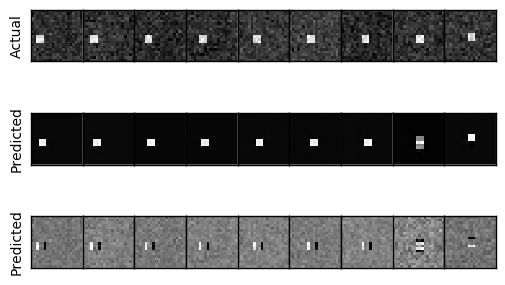

In [49]:
i=7

nt = 9
gs = gridspec.GridSpec(3, nt)
gs.update(wspace=0., hspace=0.)
for t in range(nt):
        plt.subplot(gs[t])
        plt.imshow(X_train[i,t,0,:,:].data.cpu().numpy(), interpolation='none')
        plt.gray()
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        plt.imshow(predicted_frames[i,t,0,:,:].data.cpu().numpy(), interpolation='none')
        plt.gray()
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)
            
        plt.subplot(gs[t + 2*nt])
        plt.imshow(X_train[i,t,0, :,:].data.cpu().numpy()-predicted_frames[i,t,0,:,:].data.cpu().numpy(), interpolation='none')
        plt.gray()
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)
            
plt.show()

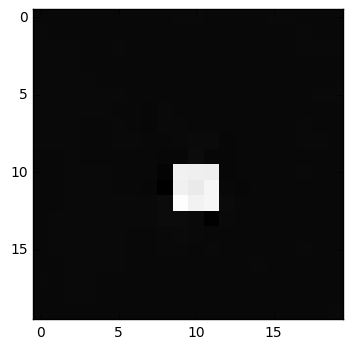

In [50]:
plt.imshow(predicted_frames[i,6,0,:,:].data.cpu().numpy(), interpolation='none')
plt.show()

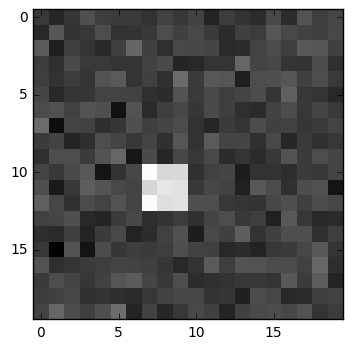

In [35]:
plt.imshow(X_train[i,5,0,:,:].data.cpu().numpy(), interpolation='none')
plt.show()

In [44]:
data_container['trajectories'][15]

array([[  1.,  10.],
       [  2.,  10.],
       [  3.,  10.],
       [  4.,  10.],
       [  5.,  10.],
       [  6.,  10.],
       [  7.,  10.],
       [  8.,  10.],
       [  9.,  10.],
       [  9.,  11.]])